In [14]:
# 선행 score api
#sample_data = pd.read_csv("sample_data.csv")
# 예시 데이터 return 값 : [True, False, True, False, True]
sample_data = [-10, 10, 90, -50, 70]

# roll 값이 70 이상이면 True(기울어짐)), 아니면 False
def is_fallen(sample_data: list) -> int:
    critical_angle = 70
    return [1 if abs(roll) > critical_angle else 0 for roll in sample_data]

# 위의 roll 값 기준으로 점수 계산
def score1(sample_data: list) -> int:
    weight = 10
    return list(map(lambda x: x * weight, is_fallen(sample_data)))
score1(sample_data)



[0, 0, 10, 0, 0]

In [ ]:
# socre2

sample_data = [10, 20, 30, 40, 50]



def score2(sample_data: list) -> int:
    weight = 20
    return list(map(lambda x: x * weight, is_fallen(sample_data)))
score2(sample_data)

In [ ]:
import json
import boto3

def lambda_handler(event, context):
    # Bedrock 클라이언트 생성
    bedrock = boto3.client('bedrock-runtime')
    
    # 입력 텍스트 가져오기 (event에서 body 파싱)
    try:
        body = json.loads(event.get('body', '{}'))
        input_text = body.get('text', '')
    except:
        return {
            'statusCode': 400,
            'body': json.dumps({'error': '잘못된 입력 형식입니다.'})
        }
    
    # Anthropic Claude 모델 파라미터 설정
    request_body = {
        "prompt": f"\n\nHuman: Tell me about Trump. \n\nAssistant:",
        "max_tokens_to_sample": 500,
        "temperature": 0.7,
        "top_p": 1
    }
    
    
    try:
        # Bedrock 모델 호출
        response = bedrock.invoke_model(
            modelId='anthropic.claude-3-5-sonnet-20241022-v2:0',
            body=json.dumps(request_body)
        )
        
        # 응답 처리
        response_body = json.loads(response.get('body').read())
        completion = response_body.get('completion', '')
        
        return {
            'statusCode': 200,
            'body': json.dumps({
                'response': completion
            })
        }
        
    except Exception as e:
        return {
            'statusCode': 500,
            'body': json.dumps({
                'error': f'모델 호출 중 오류가 발생했습니다: {str(e)}'
            })
        }

In [2]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
sampel_data = pd.DataFrame({
    '주행거리': [10, 5, 3, 2, 7],
    '구간별 평균속도(시간)': [1, 0, 1, 0, 1],
    '구간별 급정거 횟수': [1, 0, 1, 0, 1],
    '신호등 구간 감소 여부': [1, 0, 1, 0, 1],
    '회전 구간 감속 여부': [1, 0, 1, 0, 1],
    '급회전 횟수': [1, 0, 1, 0, 1],
    '안전거리 준수 여부': [1, 0, 1, 0, 1],
})

In [ ]:
Tree = DecisionTreeClassifier()
Tree.fit(sampel_data, )

Original Data:
   latitude  longitude           timestamp
0   37.5665   126.9780 2025-01-12 10:00:00
1   37.5675   126.9775 2025-01-12 10:05:00
2   37.5660   126.9783 2025-01-12 10:10:00
3   37.5658   126.9790 2025-01-12 10:15:00
4   37.5655   126.9785 2025-01-12 10:20:00
5   37.6000   126.9500 2025-01-12 10:25:00

Data with Clusters:
   latitude  longitude           timestamp  cluster
0   37.5665   126.9780 2025-01-12 10:00:00        0
1   37.5675   126.9775 2025-01-12 10:05:00        0
2   37.5660   126.9783 2025-01-12 10:10:00        0
3   37.5658   126.9790 2025-01-12 10:15:00        0
4   37.5655   126.9785 2025-01-12 10:20:00        0
5   37.6000   126.9500 2025-01-12 10:25:00       -1


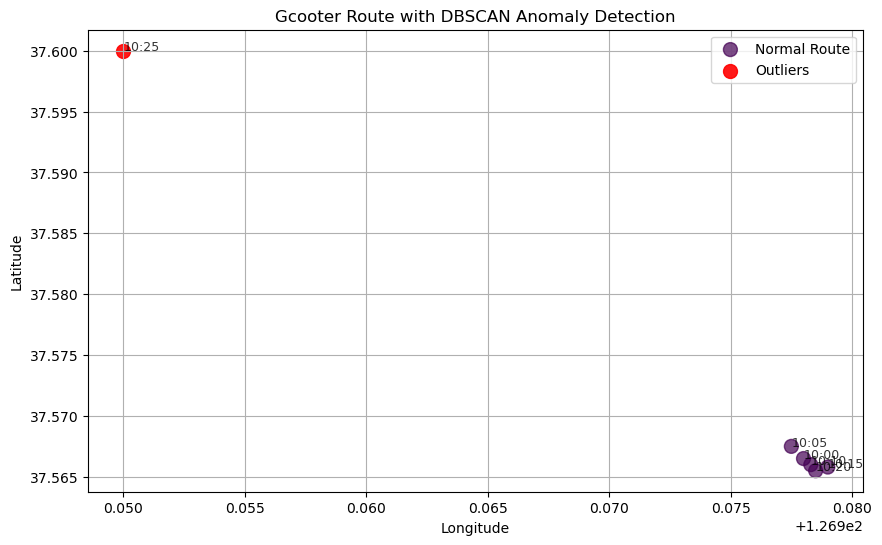

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. 예제 데이터 생성 (지쿠터 이동 경로: 위도, 경도)
def generate_sample_data():
    data = {
        "latitude": [37.5665, 37.5675, 37.5660, 37.5658, 37.5655, 37.6000],  # 위도
        "longitude": [126.9780, 126.9775, 126.9783, 126.9790, 126.9785, 126.9500],  # 경도
        "timestamp": [
            "2025-01-12 10:00:00",
            "2025-01-12 10:05:00",
            "2025-01-12 10:10:00",
            "2025-01-12 10:15:00",
            "2025-01-12 10:20:00",
            "2025-01-12 10:25:00"
        ]  # 시간 정보
    }
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

# 2. DBSCAN 기반 이상치 탐지
def detect_outliers_with_dbscan(df, eps=0.001, min_samples=2):
    # 위도와 경도 데이터를 사용
    coordinates = df[['latitude', 'longitude']].values

    # DBSCAN 모델 생성 및 학습
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")  # eps: 거리 기준, min_samples: 최소 샘플 수
    df['cluster'] = dbscan.fit_predict(coordinates)  # 클러스터 레이블 (-1은 이상치)
    
    return df

# 3. 이동 경로 시각화
def plot_routes(df):
    plt.figure(figsize=(10, 6))
    
    # 정상 경로와 이상치 분리
    normal_data = df[df['cluster'] != -1]
    outliers = df[df['cluster'] == -1]

    # 정상 데이터 플롯
    plt.scatter(normal_data['longitude'], normal_data['latitude'], c=normal_data['cluster'], cmap='viridis', label="Normal Route", s=100, alpha=0.7)
    # 이상치 데이터 플롯
    plt.scatter(outliers['longitude'], outliers['latitude'], c='red', label="Outliers", s=100, alpha=0.9)

    # 그래프 꾸미기
    for _, row in df.iterrows():
        plt.text(row['longitude'], row['latitude'], row['timestamp'].strftime('%H:%M'), fontsize=9, alpha=0.8)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Gcooter Route with DBSCAN Anomaly Detection")
    plt.legend()
    plt.grid()
    plt.show()

# 메인 실행
if __name__ == "__main__":
    # 1. 샘플 데이터 생성
    scooter_data = generate_sample_data()
    print("Original Data:")
    print(scooter_data)

    # 2. 이상치 탐지
    scooter_data_with_clusters = detect_outliers_with_dbscan(scooter_data, eps=0.002, min_samples=2)
    print("\nData with Clusters:")
    print(scooter_data_with_clusters)

    # 3. 이동 경로 시각화
    plot_routes(scooter_data_with_clusters)

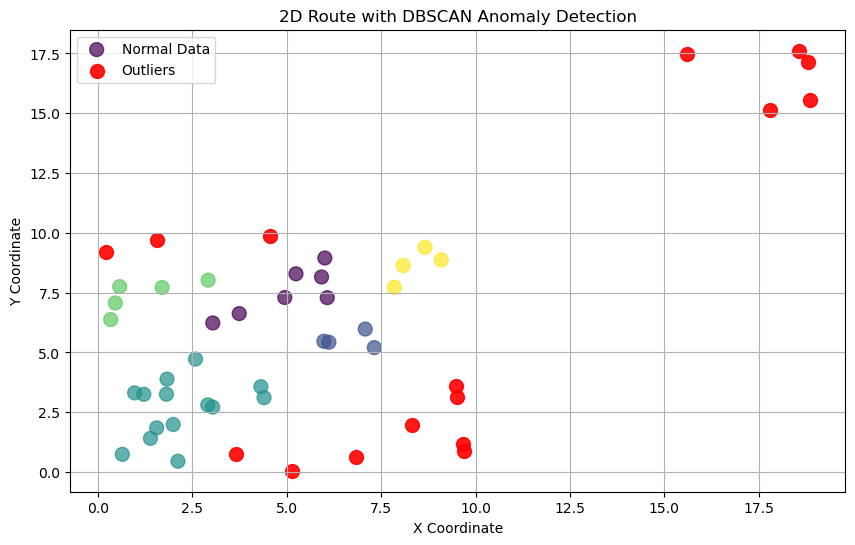

In [7]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# 1. 50개 데이터 생성 (임의의 x, y 좌표)
def generate_sample_data_50():
    np.random.seed(42)
    # 정상 데이터
    x_normal = np.random.uniform(0, 10, 45)
    y_normal = np.random.uniform(0, 10, 45)

    # 이상치 데이터
    x_outliers = np.random.uniform(15, 20, 5)
    y_outliers = np.random.uniform(15, 20, 5)

    # 합치기
    x = np.concatenate([x_normal, x_outliers])
    y = np.concatenate([y_normal, y_outliers])

    data = pd.DataFrame({'x': x, 'y': y})
    return data

# 2. DBSCAN 이상치 탐지
def detect_outliers_with_dbscan_50(data, eps=1.5, min_samples=3):
    coordinates = data[['x', 'y']].values

    # DBSCAN 모델
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['cluster'] = dbscan.fit_predict(coordinates)  # 클러스터 레이블 (-1은 이상치)
    
    return data

# 3. 2D 시각화
def plot_routes_2d(data):
    plt.figure(figsize=(10, 6))
    
    # 정상 데이터와 이상치 분리
    normal_data = data[data['cluster'] != -1]
    outliers = data[data['cluster'] == -1]

    # 정상 데이터
    plt.scatter(normal_data['x'], normal_data['y'], c=normal_data['cluster'], cmap='viridis', label="Normal Data", s=100, alpha=0.7)
    # 이상치
    plt.scatter(outliers['x'], outliers['y'], c='red', label="Outliers", s=100, alpha=0.9)

    # 그래프 설정
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("2D Route with DBSCAN Anomaly Detection")
    plt.legend()
    plt.grid()
    plt.show()

# 실행
data_50 = generate_sample_data_50()
data_50_with_clusters = detect_outliers_with_dbscan_50(data_50)
plot_routes_2d(data_50_with_clusters)

In [ ]:
#이거 생존!!
import boto3
import json

def lambda_handler(event, context):
    # Bedrock 클라이언트 생성
    bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')

    # Anthropic Claude 모델 파라미터 설정
    body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 512,
            "messages": [
                {
                    "role": "user",
                    "content": [
                    {
                        "type": "text",
                        "text": "tell me about the trump."
                    }
                    ]
                }
            ],
            "temperature": 0.5,
            "top_p": 0.9
        })

    try:
        # Bedrock 모델 호출
        response = bedrock.invoke_model(
            modelId='anthropic.claude-3-sonnet-20240229-v1:0',
            body=body
        )
        
        # 응답 처리
        response_body = json.loads(response['body'].read())
        # completion 대신 content 사용
        content = response_body['content'][0]['text']
        
        return {
            'statusCode': 200,
            'body': json.dumps({
                'response': content
            })
        }
        
    except Exception as e:
        return {
            'statusCode': 500,
            'body': json.dumps({
                'error': f'error while calling the model: {str(e)}'
            })
        }

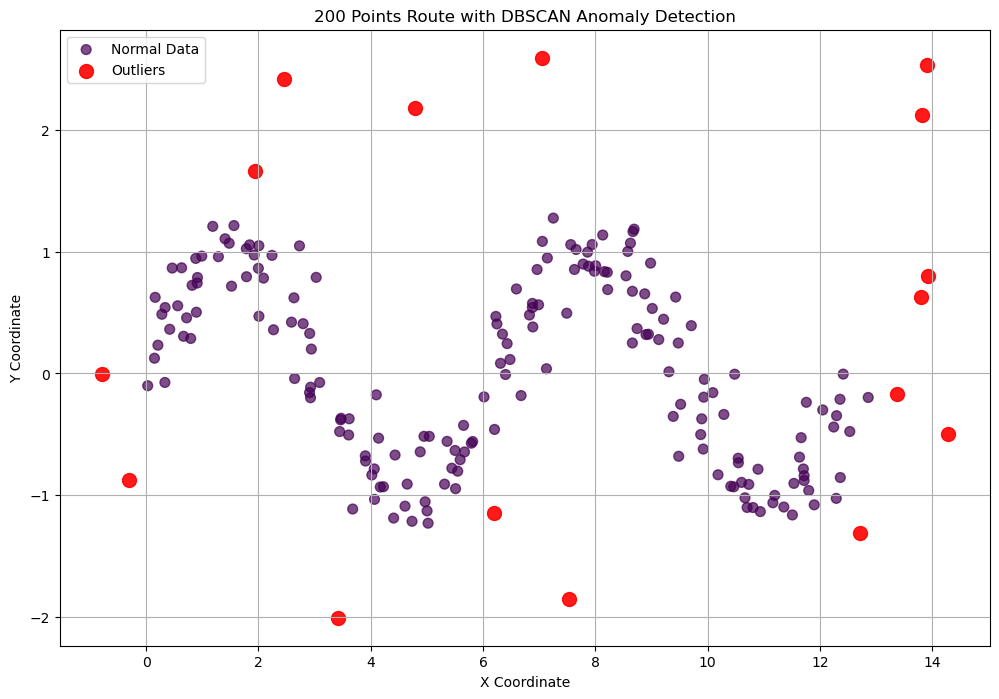

In [8]:
# line_plot을 하고 중간에 scater
# 1. 200개 데이터 생성 (구불구불한 경로와 주변 Outlier 포함)
def generate_sample_data_200():
    np.random.seed(42)
    
    # 정상 데이터: 구불구불한 경로 생성
    t = np.linspace(0, 4 * np.pi, 180)  # 경로의 구불구불한 패턴 (사인 곡선)
    x_normal = t + np.random.normal(0, 0.3, 180)  # 약간의 노이즈 추가
    y_normal = np.sin(t) + np.random.normal(0, 0.2, 180)  # 사인 패턴

    # 이상치 데이터: 정상 데이터 근처에 랜덤하게 분포
    x_outliers = np.random.uniform(min(x_normal) - 1, max(x_normal) + 1, 20)
    y_outliers = np.random.uniform(min(y_normal) - 1, max(y_normal) + 1, 20)

    # 데이터프레임으로 합치기
    x = np.concatenate([x_normal, x_outliers])
    y = np.concatenate([y_normal, y_outliers])

    data = pd.DataFrame({'x': x, 'y': y})
    return data

# 2. DBSCAN 이상치 탐지
def detect_outliers_with_dbscan_200(data, eps=0.5, min_samples=5):
    coordinates = data[['x', 'y']].values

    # DBSCAN 모델
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['cluster'] = dbscan.fit_predict(coordinates)  # 클러스터 레이블 (-1은 이상치)
    
    return data

# 3. 2D 시각화
def plot_routes_2d_200(data):
    plt.figure(figsize=(12, 8))
    
    # 정상 데이터와 이상치 분리
    normal_data = data[data['cluster'] != -1]
    outliers = data[data['cluster'] == -1]

    # 정상 데이터
    plt.scatter(normal_data['x'], normal_data['y'], c=normal_data['cluster'], cmap='viridis', label="Normal Data", s=50, alpha=0.7)
    # 이상치
    plt.scatter(outliers['x'], outliers['y'], c='red', label="Outliers", s=100, alpha=0.9)

    # 그래프 설정
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("200 Points Route with DBSCAN Anomaly Detection")
    plt.legend()
    plt.grid()
    plt.show()

# 실행
data_200 = generate_sample_data_200()
data_200_with_clusters = detect_outliers_with_dbscan_200(data_200)
plot_routes_2d_200(data_200_with_clusters)

{'figure': <Figure size 1200x800 with 1 Axes>,
 'normal_points': {'data': [{'x': 0.0, 'y': 0.0, 'cluster': -1},
   {'x': 0.2564565431501872, 'y': 0.25365458390950735, 'cluster': -1},
   {'x': 0.5129130863003744, 'y': 0.49071755200393785, 'cluster': -1},
   {'x': 0.7693696294505615, 'y': 0.6956825506034864, 'cluster': -1},
   {'x': 2.5645654315018716, 'y': 0.545534901210549, 'cluster': -1},
   {'x': 2.821021974652059, 'y': 0.3151082180236209, 'cluster': -1},
   {'x': 3.077478517802246, 'y': 0.06407021998071323, 'cluster': -1},
   {'x': 3.333935060952433, 'y': -0.05261697844738025, 'cluster': -1},
   {'x': 3.5903916041026207, 'y': -0.433883739117558, 'cluster': -1},
   {'x': 3.8468481472528078, 'y': -0.6482283953077882, 'cluster': -1},
   {'x': 4.103304690402995, 'y': -0.8201722545969556, 'cluster': -1},
   {'x': 4.359761233553182, 'y': -0.7701420701672144, 'cluster': -1},
   {'x': 4.616217776703369, 'y': -0.9953791129491981, 'cluster': -1},
   {'x': 4.872674319853556, 'y': -1.1054053921

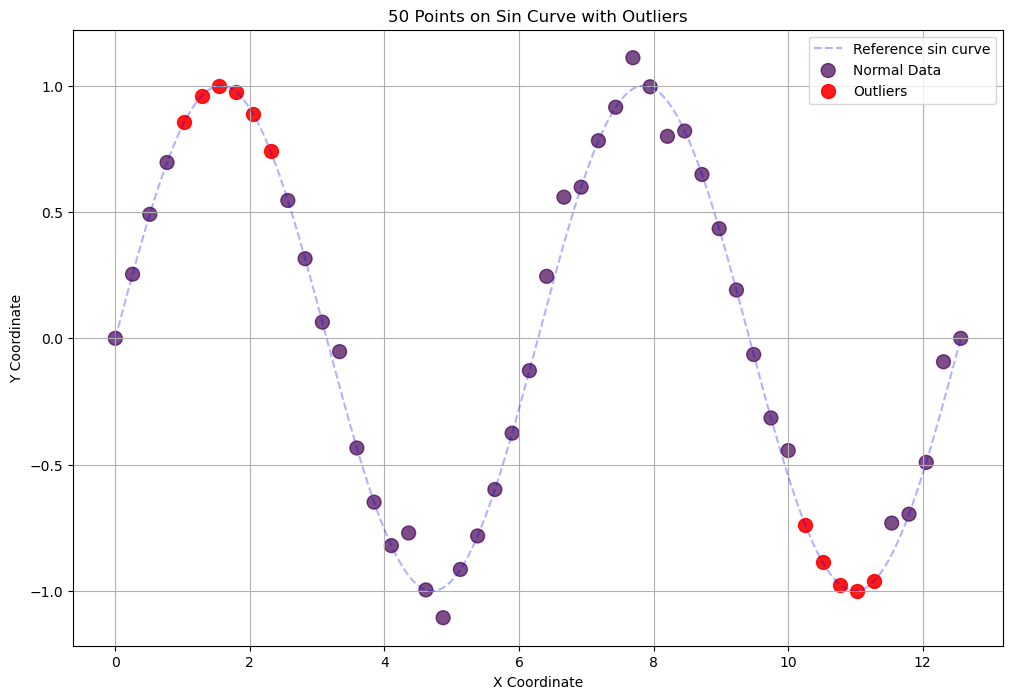

In [18]:
import pickle

def generate_sample_data_50():
    np.random.seed(42)
    
    # 50개의 등간격 포인트 생성
    t = np.linspace(0, 4 * np.pi, 50)
    x = t
    y = np.sin(t)
    
    # 무작위로 10개의 인덱스 선택하여 이상치 생성
    outlier_indices = np.random.choice(50, 10, replace=False)
    
    # 선택된 포인트들을 sin 그래프에서 약간 벗어나게 조정
    y[outlier_indices] += np.random.uniform(0.5, 1.0, 10) * np.random.choice([-0.2, 0.2], 10)
    
    data = pd.DataFrame({'x': x, 'y': y})
    return data

def detect_outliers_with_dbscan_50(data, eps=0.3, min_samples=3):
    coordinates = data[['x', 'y']].values
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    data['cluster'] = dbscan.fit_predict(coordinates)

    # 모델 저장
    with open('dbscan_model.pkl', 'wb') as f:
        pickle.dump(dbscan, f)
    return data

def plot_routes_2d_50(data):
    plt.figure(figsize=(12, 8))
    
    # 기준이 되는 sin 곡선 그리기
    t = np.linspace(0, 4 * np.pi, 200)
    plt.plot(t, np.sin(t), 'b--', alpha=0.3, label='Reference sin curve')
    
    normal_data = data[data['cluster'] == -1]
    outliers = data[data['cluster'] != -1]
    
    plt.scatter(normal_data['x'], normal_data['y'], c=normal_data['cluster'], 
               cmap='viridis', label="Normal Data", s=100, alpha=0.7)
    plt.scatter(outliers['x'], outliers['y'], c='red', label="Outliers", 
               s=100, alpha=0.9)
    
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("50 Points on Sin Curve with Outliers")
    plt.legend()
    plt.grid(True)
    
        # 분석 결과를 딕셔너리로 반환
    result = {
        'figure': plt.gcf(),  # 현재 그래프 figure 객체
        'normal_points': {
            'data': normal_data.to_dict('records'),
            'count': len(normal_data)
        },
        'outlier_points': {
            'data': outliers.to_dict('records'),
            'count': len(outliers)
        }
    }
    return result

# 실행
data_50 = generate_sample_data_50()
data_50_with_clusters = detect_outliers_with_dbscan_50(data_50)
plot_routes_2d_50(data_50_with_clusters)



In [ ]:
# 저장된 모델 로드
with open('dbscan_model.pkl', 'rb') as f:
    loaded_dbscan = pickle.load(f)

# 로드한 모델로 예측
print(loaded_dbscan.predict([[0, 0], [12, 3]]))

In [ ]:
import boto3
import json
import base64

def lambda_handler(event, context):
    # Bedrock 클라이언트 생성
    bedrock = boto3.client('bedrock-runtime', region_name='us-east-1')

    # Anthropic Claude 모델 파라미터 설정
    image_content = event.get("base64_image")
    #base64_encoded_image = base64.b64encode(image_content).decode('utf-8')
    body = json.dumps({
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 512,
            "messages": [
                {
                    "role": "user",
                    "content": [
                    {
                        "type": "text",
                        "text": "tell me about the trump."
                    },
                    {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/png",
                                "data": image_content
                            }
                        },
                    ]
                }
            ],
            "temperature": 0.5,
            "top_p": 0.9
        })

    try:
        # Bedrock 모델 호출
        response = bedrock.invoke_model(
            modelId='anthropic.claude-3-sonnet-20240229-v1:0',
            body=bedrock_body
        )
        
        # 응답 처리
        response_body = json.loads(response['body'].read())
        # completion 대신 content 사용
        content = response_body['content'][0]['text']
        
        return {
            'statusCode': 200,
            'body': json.dumps({
                'response': content
            })
        }
        
    except Exception as e:
        return {
            'statusCode': 500,
            'body': json.dumps({
                'error': f'error while calling the model: {str(e)}'
            })
        }

In [ ]:
import boto3
import base64
import json

def lambda_handler(event, context):
    s3_client = boto3.client('s3', region_name='us-east-1')
    lambda_client = boto3.client('lambda', region_name='us-east-1')

    # S3에서 파일 경로 가져오기
    bucket_name = event.get('bucket_name', 'blackout-27')
    object_key = event.get('object_key', 'good.jpg')

    try:
        # S3에서 이미지 가져오기
        response = s3_client.get_object(Bucket=bucket_name, Key=object_key)
        image_data = response['Body'].read()  # 바이너리 데이터 읽기

        # Base64로 인코딩
        base64_image = base64.b64encode(image_data).decode('utf-8')

        # Bedrock Sonnet 모델 요청 JSON 구성
        bedrock_payload = {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 512,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image",
                            "source": {
                                "type": "base64",
                                "media_type": "image/jpeg",
                                "data": base64_image
                            }
                        },
                        {
                            "type": "text",
                            "text": "주차 규칙에 따라 이미지가 적합하게 주차되었는지 확인해 주세요."
                        }
                    ]
                }
            ],
            "temperature": 0.5,
            "top_p": 0.9
        }

        # Lambda 2 호출
        target_lambda_name = "bedrock-sonnect-image-classifier"  # Lambda 2 함수 이름
        response = lambda_client.invoke(
            FunctionName=target_lambda_name,
            InvocationType='RequestResponse',  # 동기 호출
            Payload=json.dumps({"base64_image": base64_image})
        )

        # Lambda 2 응답 읽기
        response_payload = json.load(response['Payload'])
        print(response_payload)

        return {
            "statusCode": 200,
            "body": json.dumps({
                "message": "Successfully processed and invoked Bedrock Lambda",
                "response": response_payload
            })
        }

    except Exception as e:
        print(f"Error: {e}")
        return {
            "statusCode": 500,
            "body": json.dumps({"error": str(e)})
        }